# Experimenting with impedance matching `20201103a`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from time import time, sleep
from fpga_ctrl import FpgaControl

%load_ext autoreload
%autoreload 2

In /home/kelu/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kelu/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kelu/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/kelu/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kelu/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_c

# Utilities

In [2]:
# Global constants
SAMPLES_PER_LINE = 16384
GAINS_MAX = 32
LINES_MAX = 32
SAMPLE_W = 10
SAMPLE_N = 2 ** SAMPLE_W
SAMPLE_FREQ = 63.75

In [3]:
# Utility functions
def line_to_voltage(line):
    return [((2 * 3.3) / SAMPLE_N) * ((w & (SAMPLE_N - 1)) - SAMPLE_N // 2) for w in line]

def gain_to_voltage(gain):
    return [(1.0 / SAMPLE_N) * g for g in gain]

def gain_expand(gain, length=SAMPLES_PER_LINE):
    return [gain[x // (length // GAINS_MAX)] for x in range(length)]

def gain_staircase(step_width=1, max_value=1024):
    step_val = max_value // GAINS_MAX
    return [step_val - 1 + step_val * step_width * (i // step_width) for i in range(GAINS_MAX)]

def line_complex_sin(offset = 0):
    return [int(512 + 200 * np.sin(2 * np.pi * offset * 1E6 / 127.5E6 + 2 * np.pi * i * 1E6 / 63.75E6) + 
                      100 * np.sin(2 * np.pi * offset * 2E6 / 127.5E6 + 2 * np.pi * i * 2E6 / 63.75E6 ) -
                      80 * np.sin(2 * np.pi * offset * 5E6 / 127.5E6 + 2 * np.pi * i * 5E6 / 63.75E6 ) +
                      20 * np.sin(2 * np.pi * offset * 8E6 / 127.5E6 + 2 * np.pi * i * 8E6 / 63.75E6 )) for i in range(SAMPLES_PER_LINE)]

def plot_line(title, line, gain=[0]*GAINS_MAX, xlim=None, dots=False):
    # prepare line
    _line = line_to_voltage(line)
    # prepare gain
    _gain = gain_expand(gain_to_voltage(gain), len(line))
    # prepare time
    t = [1.0 / SAMPLE_FREQ * x for x in range(len(line))]
    # build the plot
    fig, ax1 = plt.subplots(figsize=(20, 10))
    if xlim:
        ax1.set_xlim(xlim)
    ax2 = ax1.twinx()
    ax1.plot(t, _line, 'b-')
    if dots:
        ax1.plot(t, _line, 'ro')
    ax2.plot(t, _gain, 'g-')
    plt.title(title)
    ax1.set_xlabel('Time, us')
    ax1.set_ylabel('ADC, V', color='b')
    ax2.set_ylabel('DAC, V', color='g')
    plt.tight_layout()
    plt.title(title)
    plt.savefig(title+".png")
    plt.show()

def plot_line_raw(title, line, gain=[0]*GAINS_MAX, xlim=None, dots=False):
    # prepare line
    _line = [w & (SAMPLE_N - 1) for w in line]
    # prepare gain
    _gain = gain_expand(gain, len(line))
    # prepare time
    t = [x for x in range(len(line))]
    # build the plot
    fig, ax1 = plt.subplots(figsize=(20, 10))
    if xlim:
        ax1.set_xlim(xlim)
    ax2 = ax1.twinx()
    ax1.plot(t, _line, 'b-')
    if dots:
        ax1.plot(t, _line, 'ro')
    ax2.plot(t, _gain, 'g-')
    plt.title(title)
    ax1.set_xlabel('Sample n')
    ax1.set_ylabel('ADC code', color='b')
    ax2.set_ylabel('DAC code', color='g')
    plt.tight_layout()
    plt.show()

def plot_interleaved_lines(title, line0, line1, gain=[0]*GAINS_MAX, xlim=None, dots=False):
    il_len = len(line0) * 2
    il_freq = SAMPLE_FREQ * 2
    # prepare line 0
    _line0 = line_to_voltage(line0)
    t0 = [1.0 / SAMPLE_FREQ * x for x in range(len(_line0))]
    # prepare line 1
    _line1 = line_to_voltage(line1)
    t1 = [1.0 / il_freq + 1.0 / SAMPLE_FREQ * x for x in range(len(_line0))]
    # prepare interleaved line
    il_line = [_line1[i//2] if i % 2 else _line0[i//2] for i in range(il_len)]
    # prepare gain
    _gain = gain_expand(gain_to_voltage(gain), il_len)
    # prepare time
    t = [1.0 / il_freq * x for x in range(il_len)]
    # build the plot
    fig, ax1 = plt.subplots(figsize=(20, 10))
    if xlim:
        ax1.set_xlim(xlim)
    ax2 = ax1.twinx()
    ax1.plot(t, il_line, 'b-')
    if dots:
        ax1.plot(t0, _line0, 'ro')
        ax1.plot(t1, _line1, 'yo')
    ax2.plot(t, _gain, 'g-')
    plt.title(title)
    ax1.set_xlabel('Time, us')
    ax1.set_ylabel('ADC, V', color='b')
    ax2.set_ylabel('DAC, V', color='g')
    plt.tight_layout()
    plt.show()

# Acquisition demonstration

## Connect FPGA

In [46]:
# init FTDI device
fpga = FpgaControl('ftdi://ftdi:2232:/', spi_freq=8E6)
# reload configuration (optional step - just to fill BRAM (DACGAIN registers) with initial values)
fpga.reload()
# reset fpga
fpga.reset()

## Do acquisition

### Checking all is well plugged

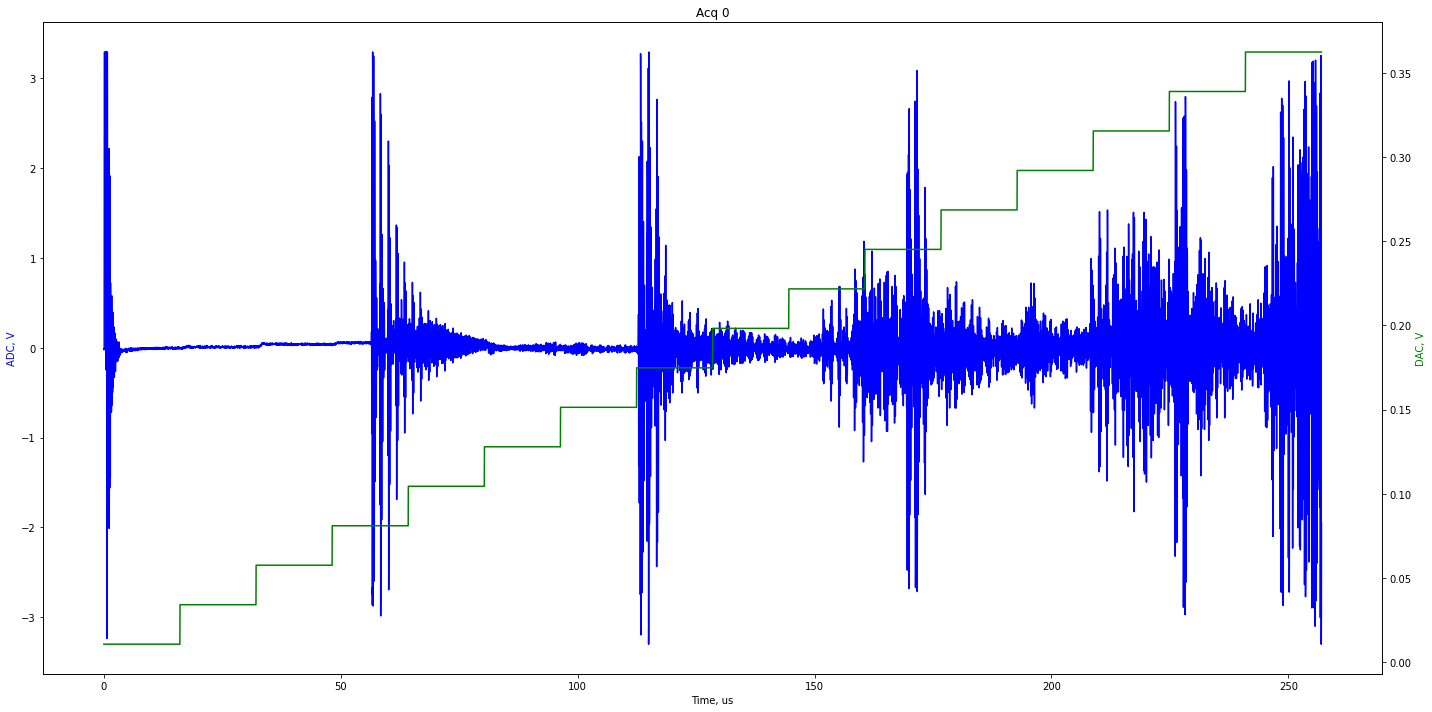

In [111]:
PONWidth = 4
gain = gain_staircase(2, 410)
fpga.csr.ponw = PONWidth
fpga.csr.interw = PONWidth
acq_res = fpga.do_acquisition(acq_lines=32, gain=gain, double_rate=True)
plot_line("Acq 0", acq_res[0], gain)

data = {}
data["gain"]=gain
data["width"] = PONWidth
data["double_rate"]="True"
for i in range(32):
    data[i]=acq_res[i]

import json

with open('smallpiezo_nothing_LtoGND+capa.json', 'w') as fp:
    json.dump(data, fp)

### Trying to find the optimal  pulse pattern for the piezo

In [84]:
gain = gain_staircase(2, 350)

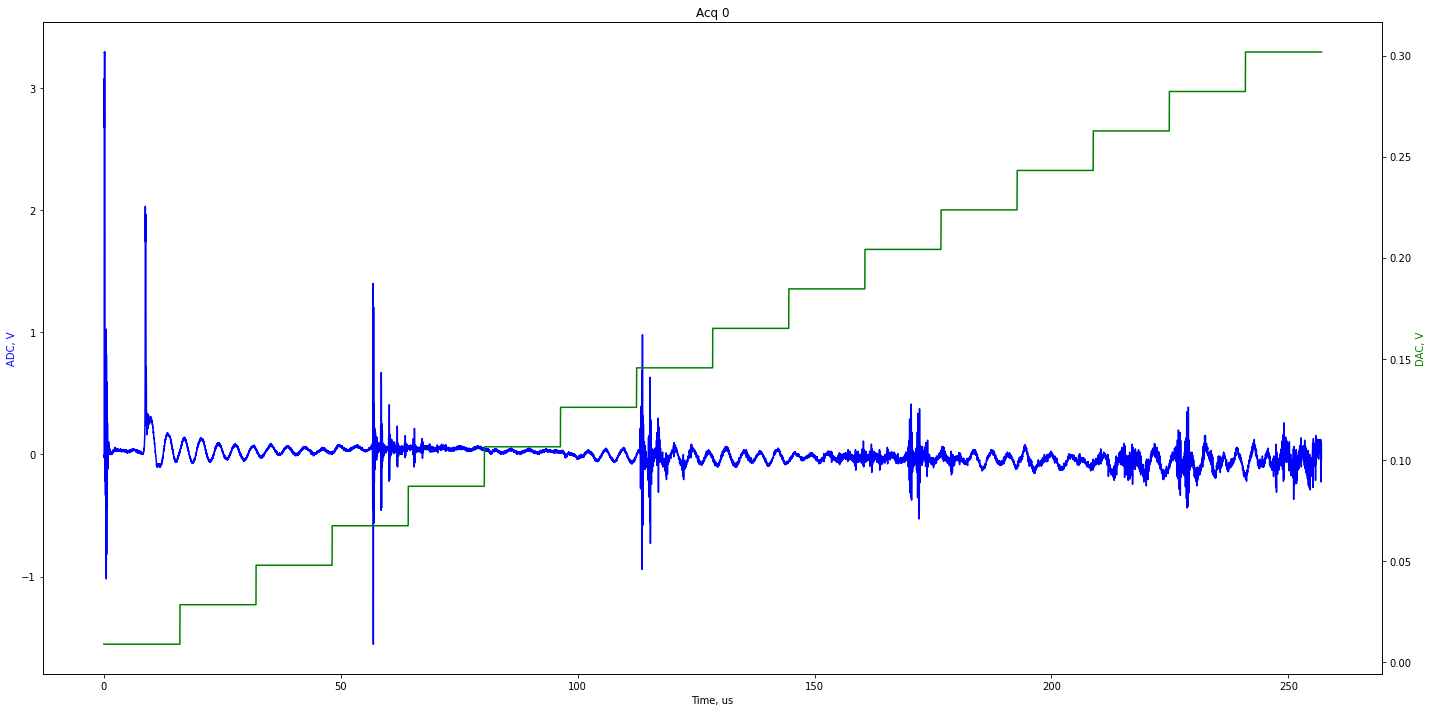

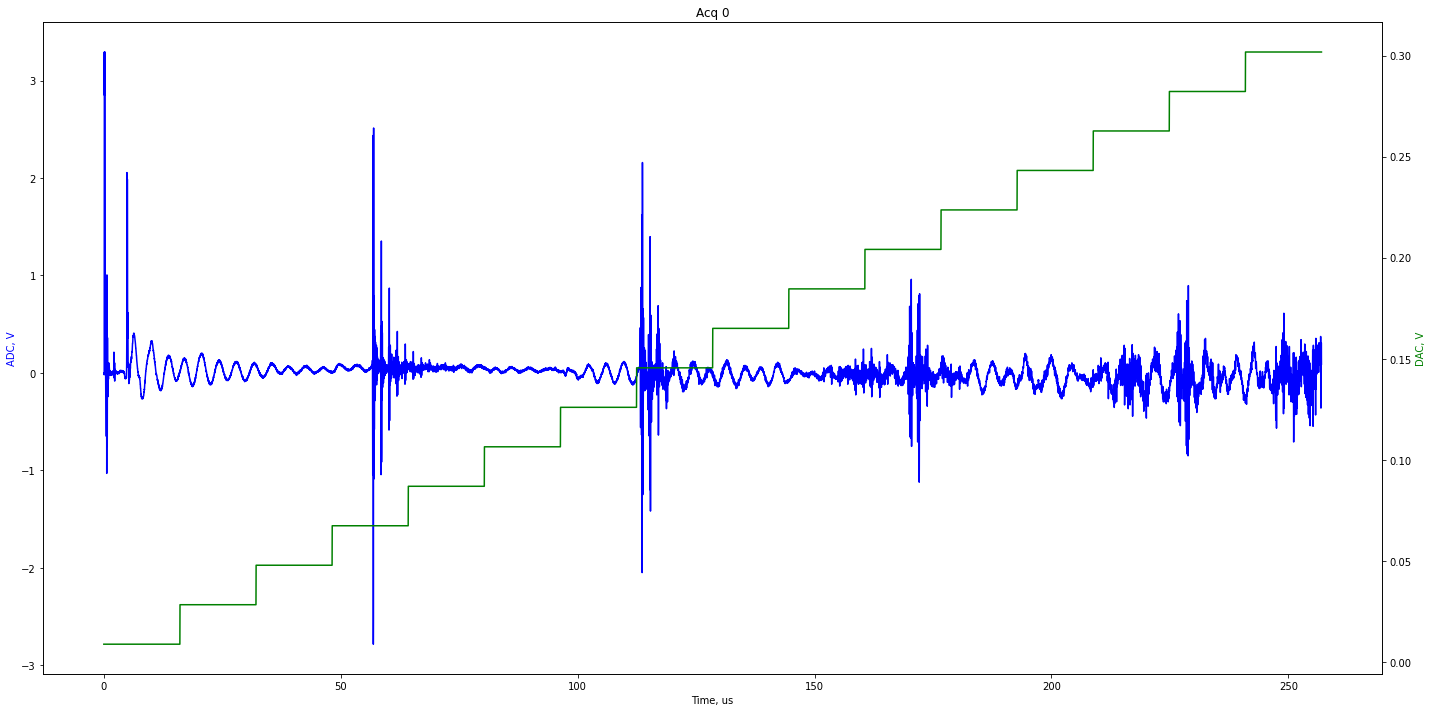

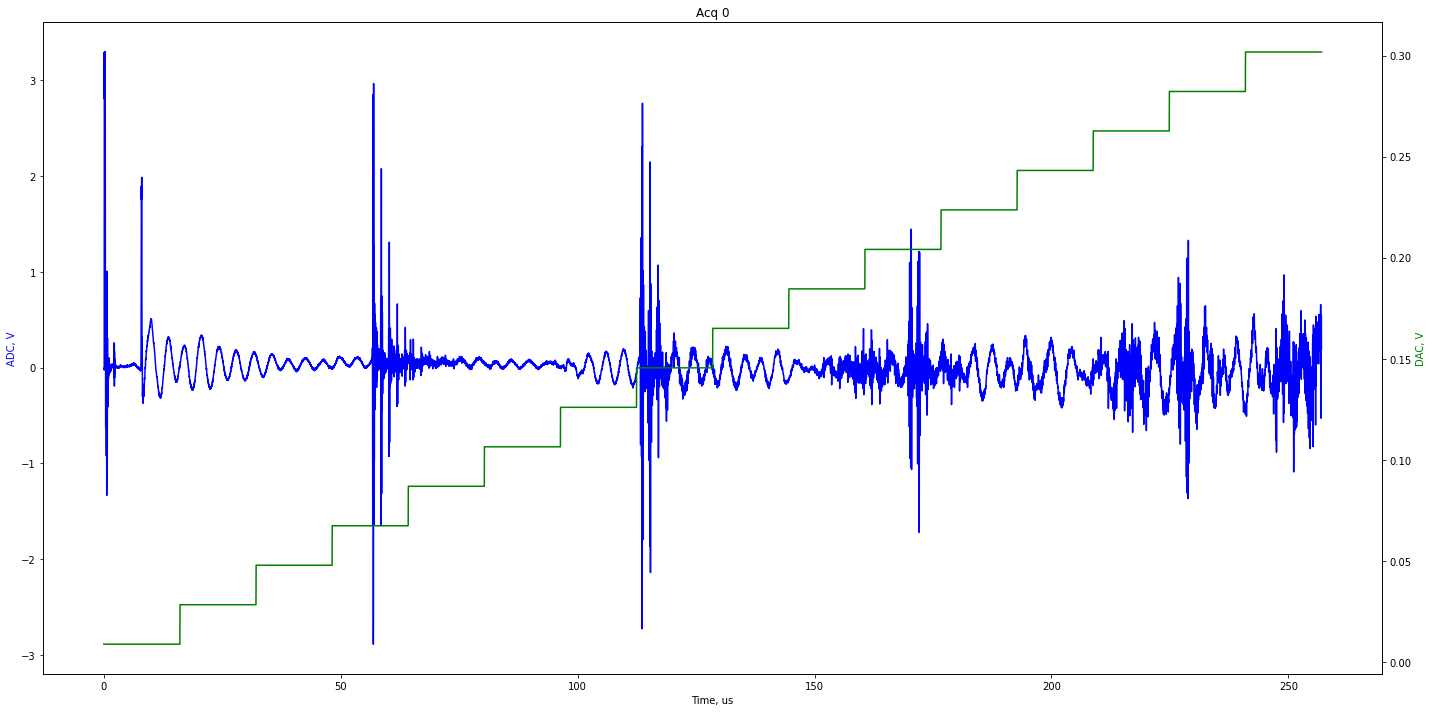

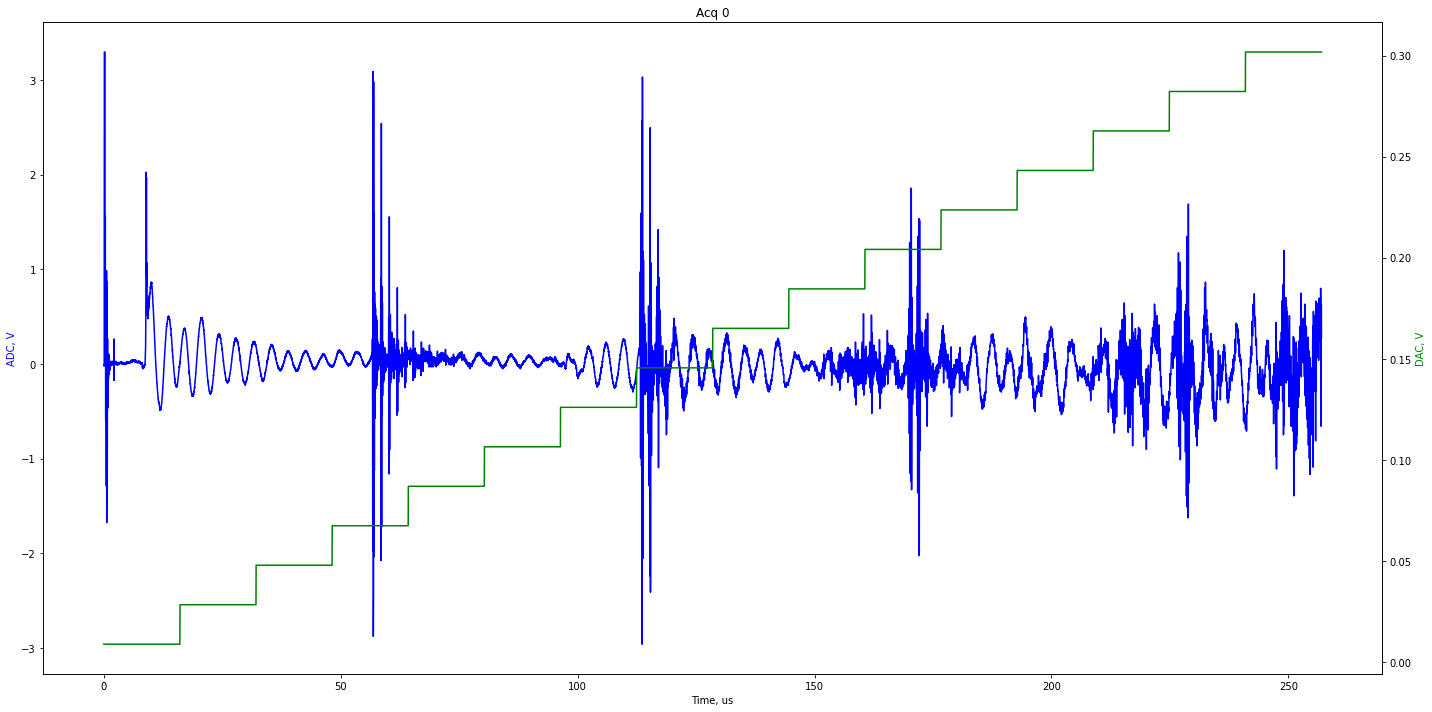

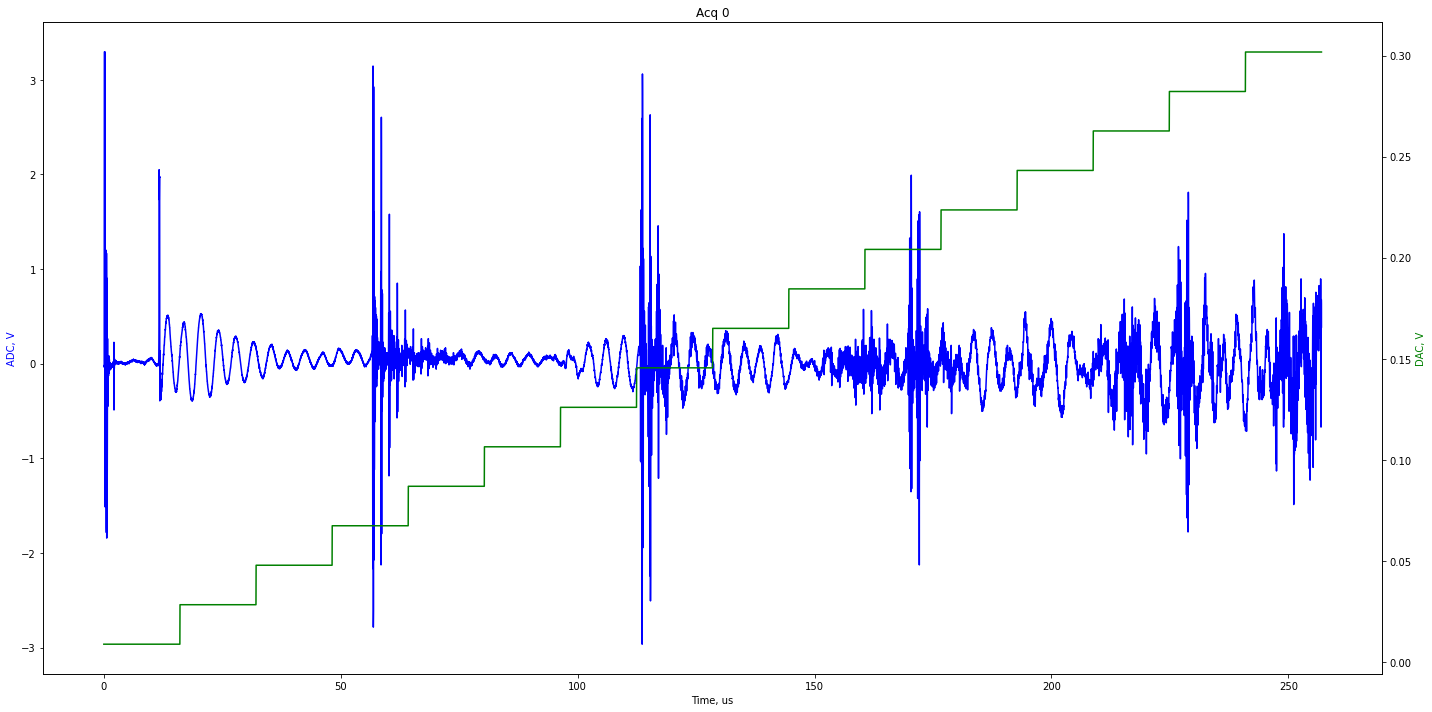

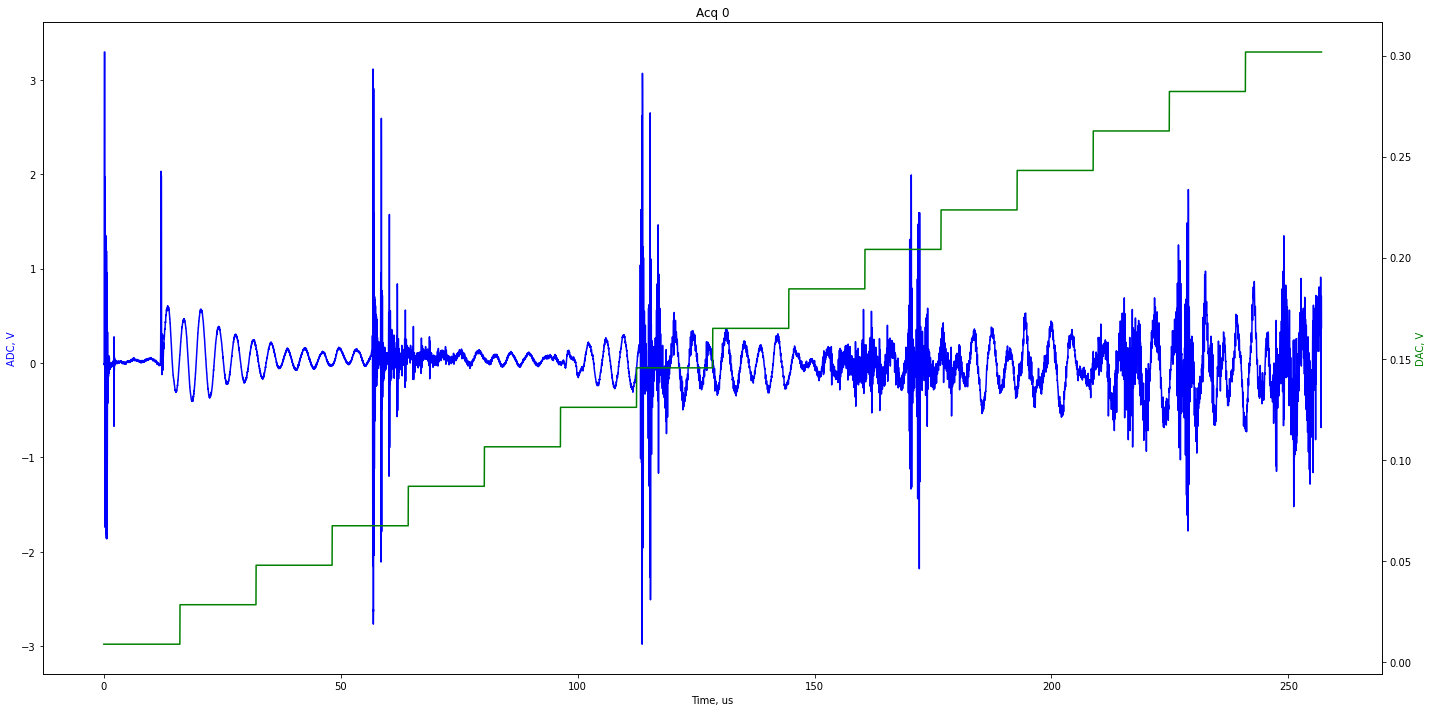

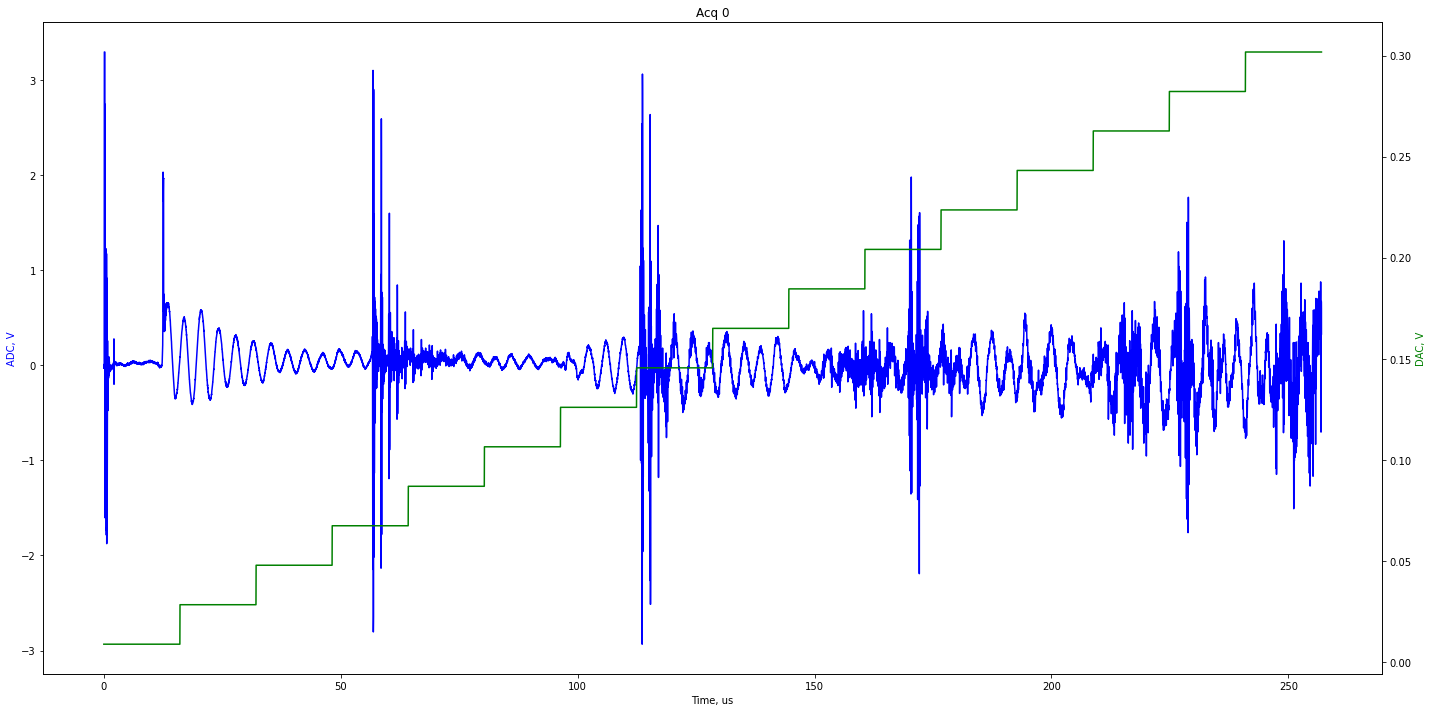

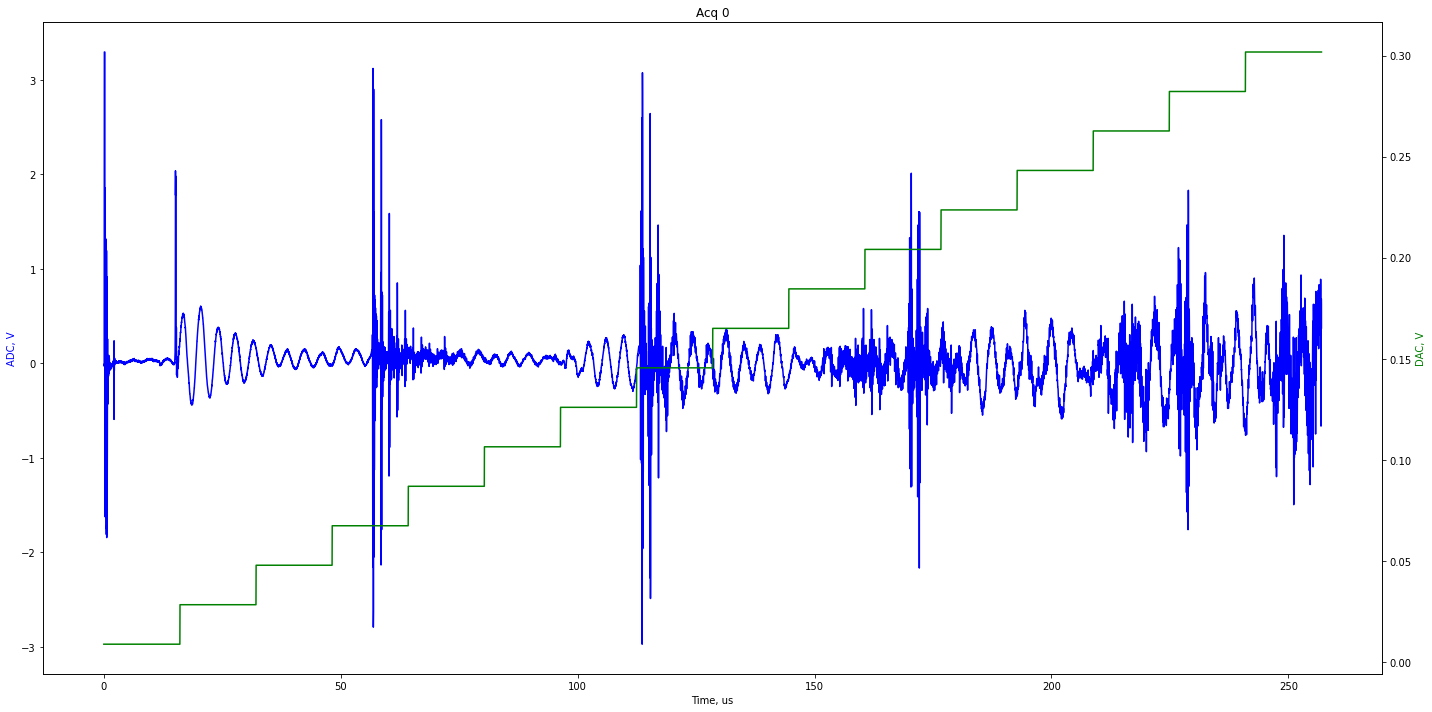

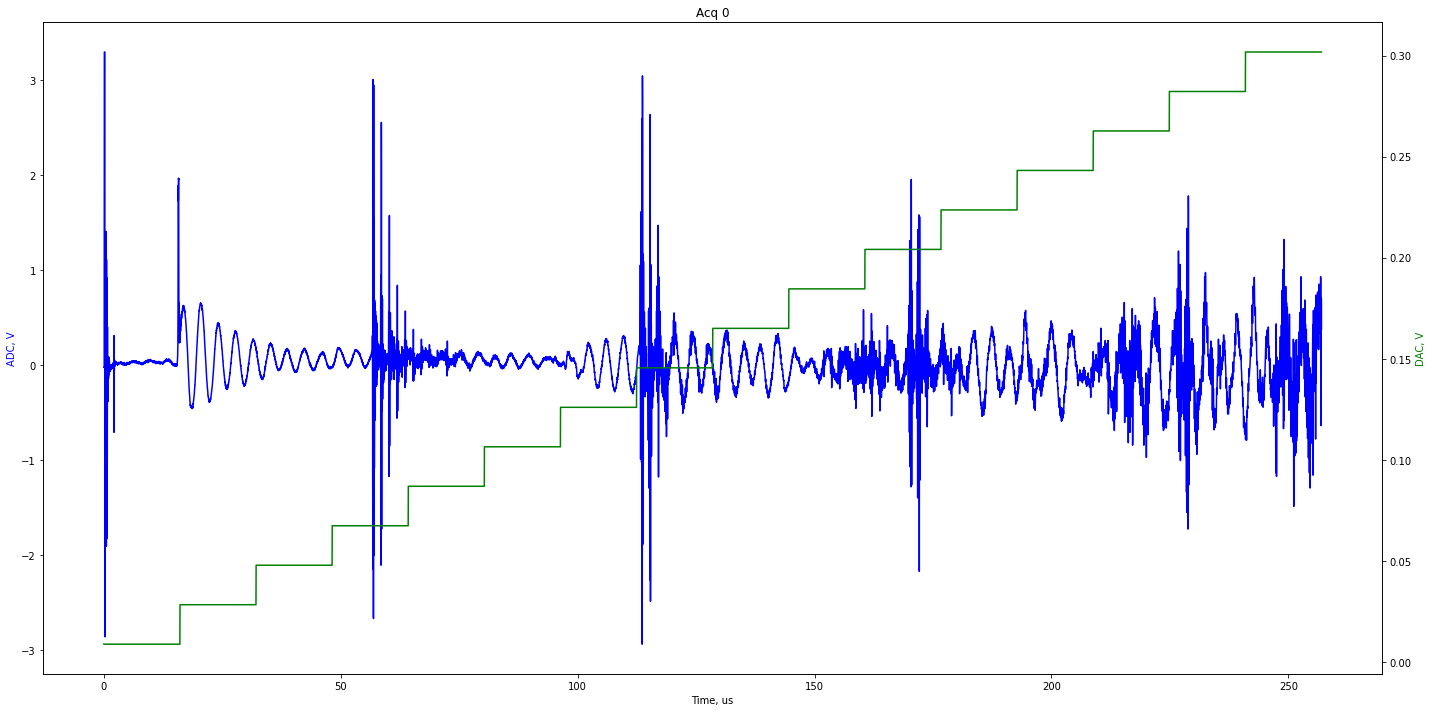

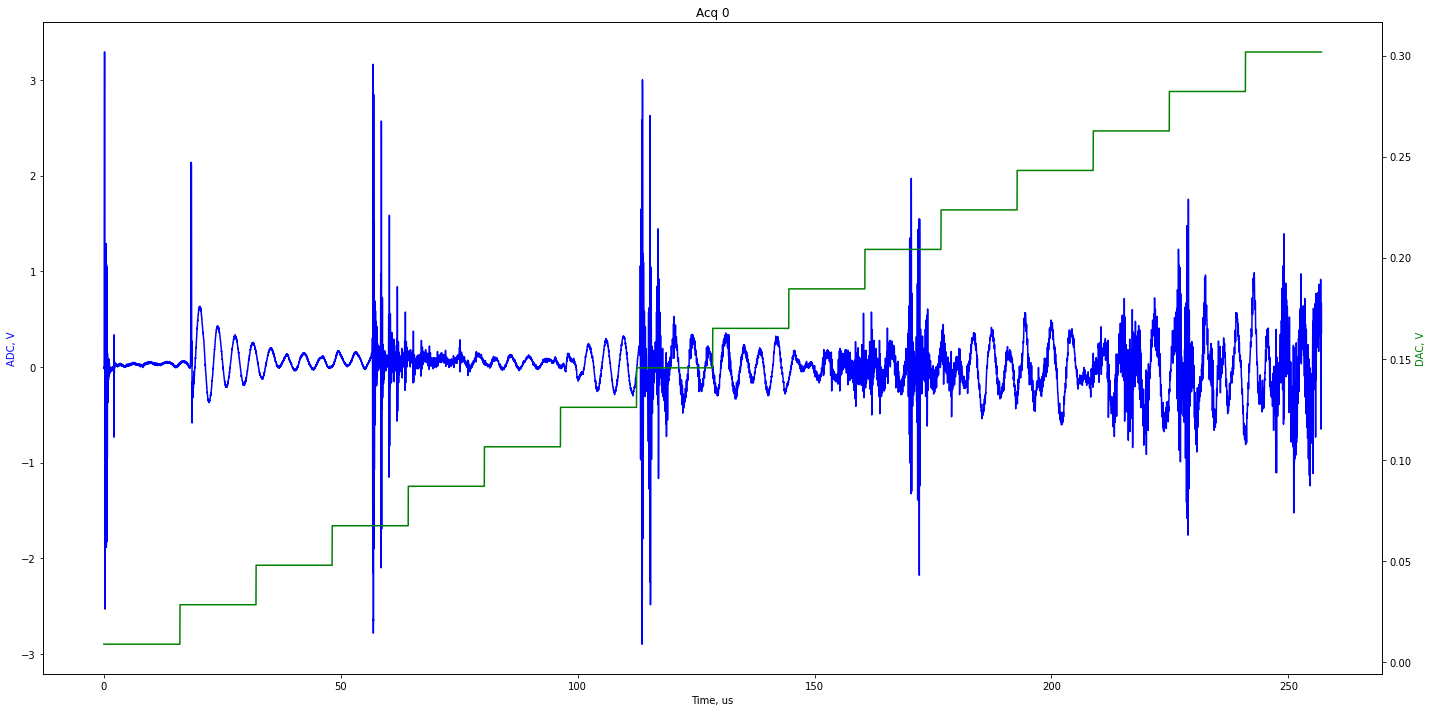

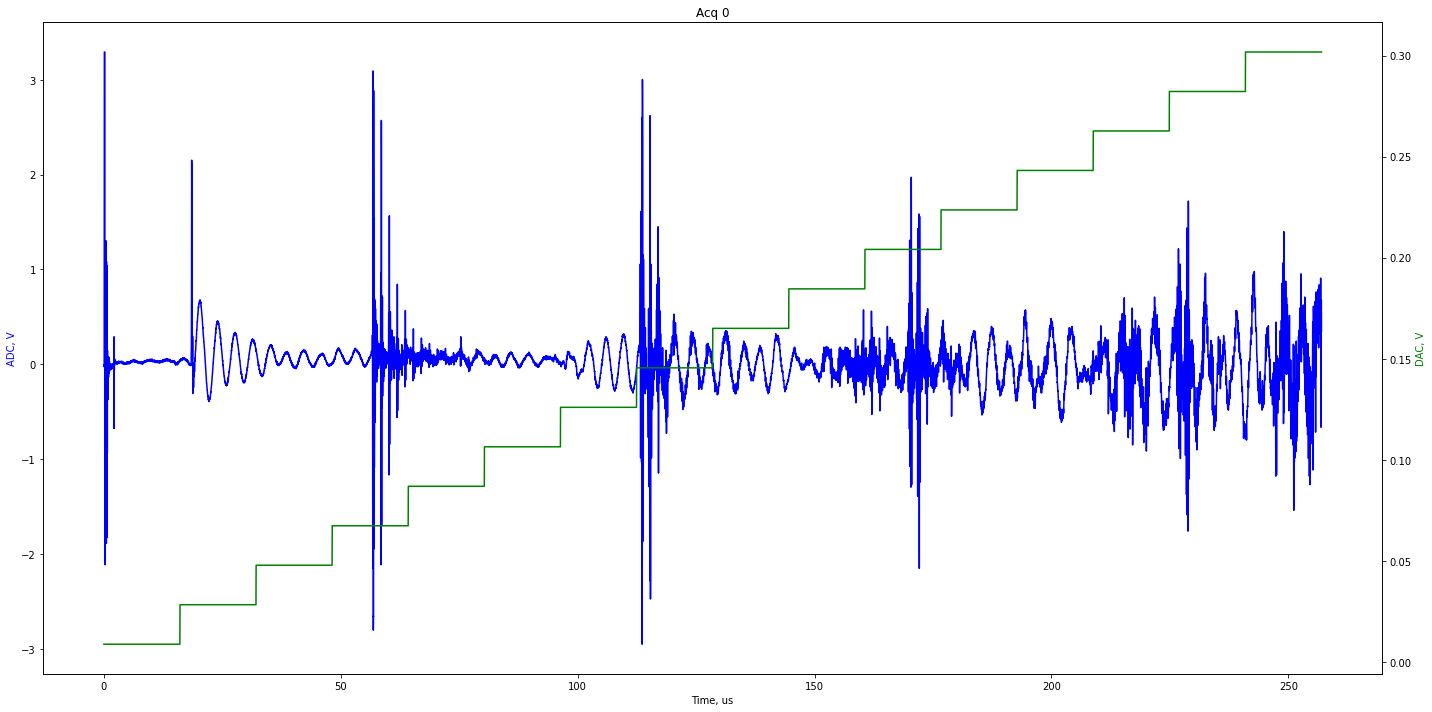

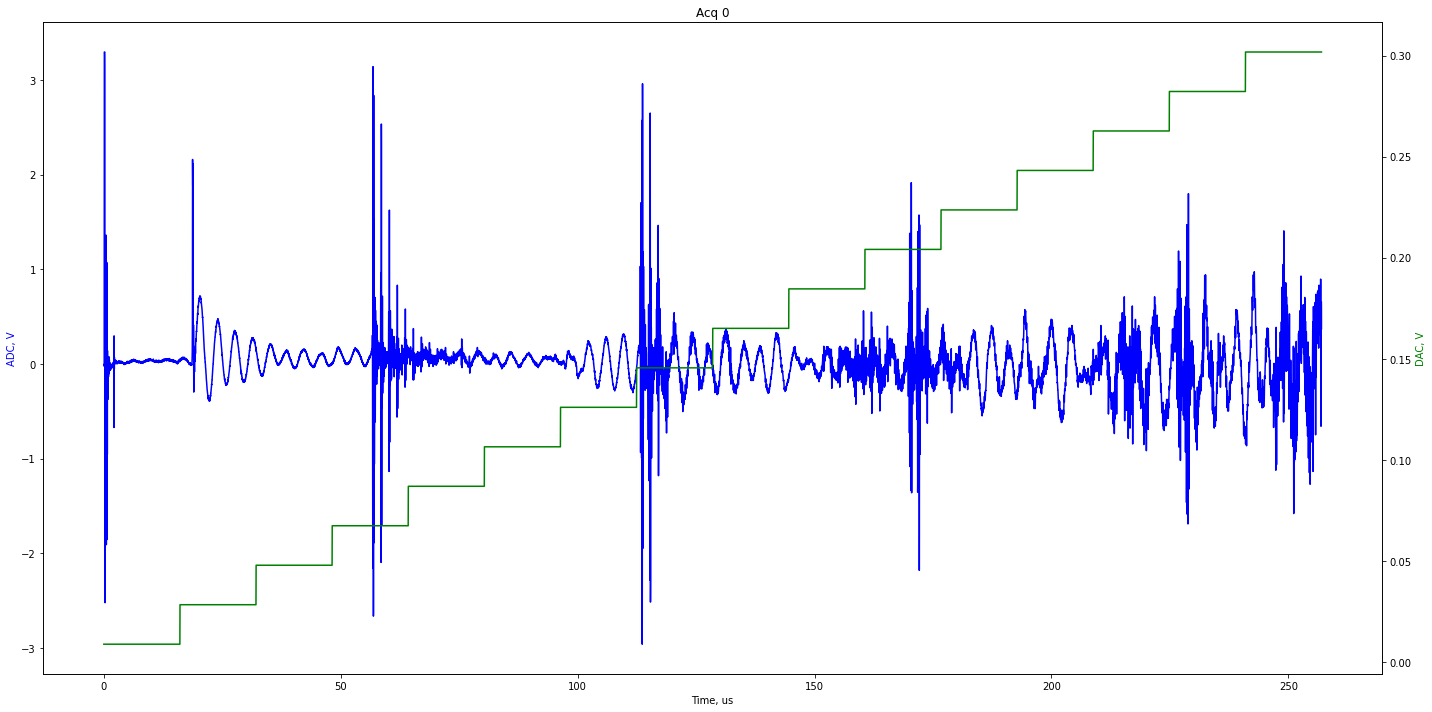

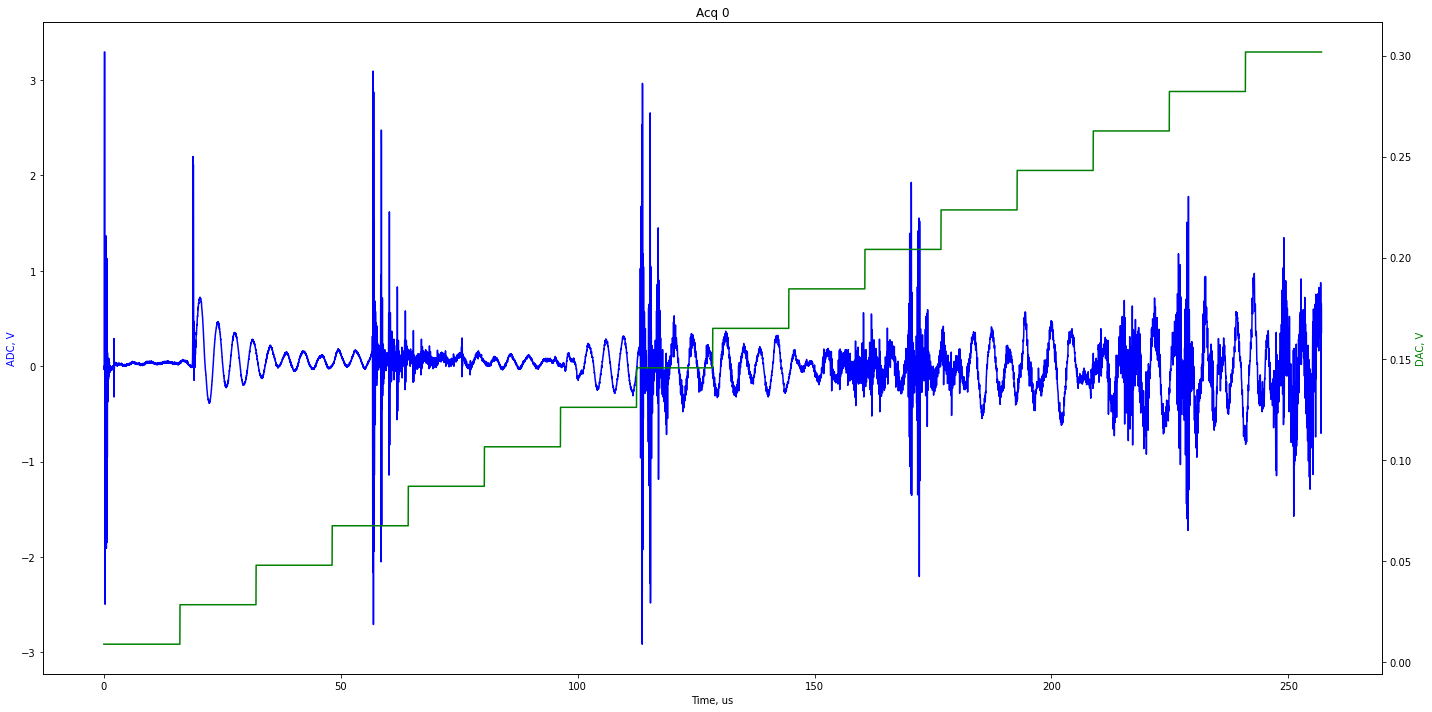

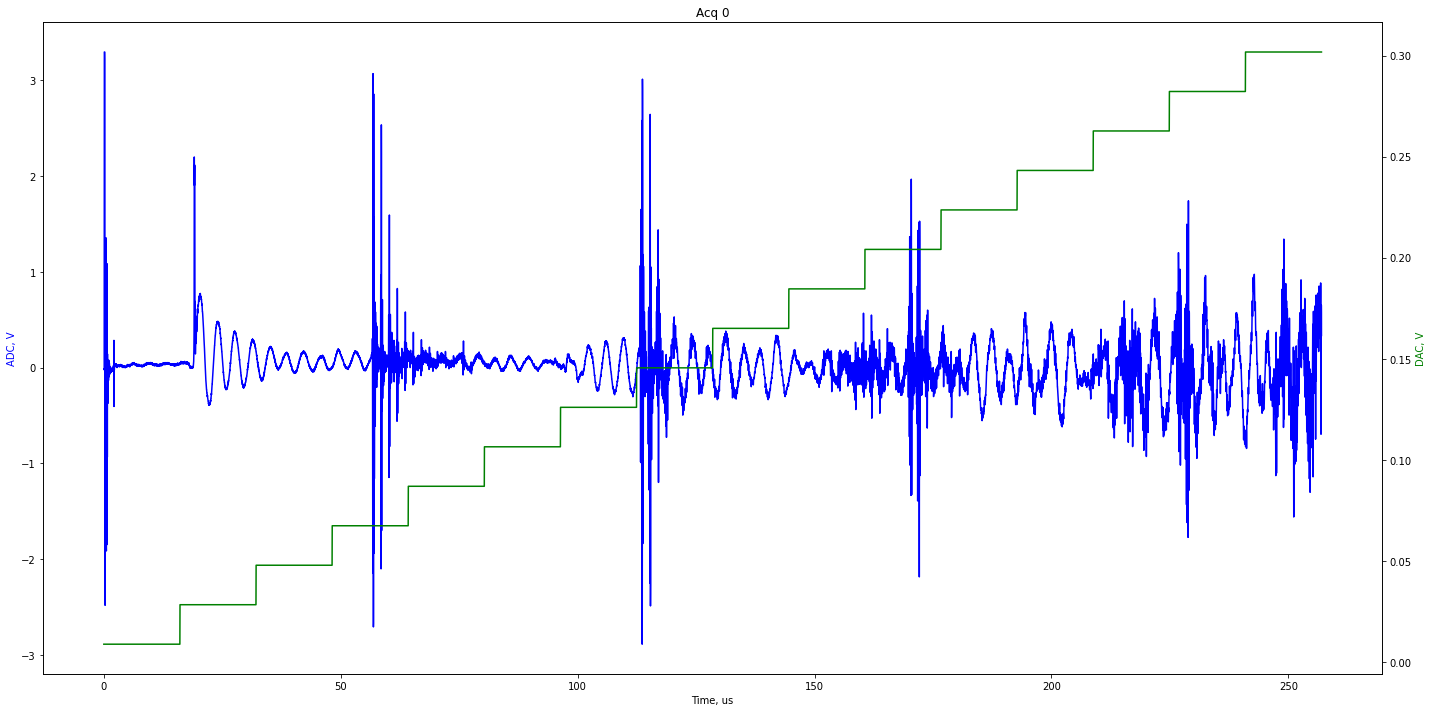

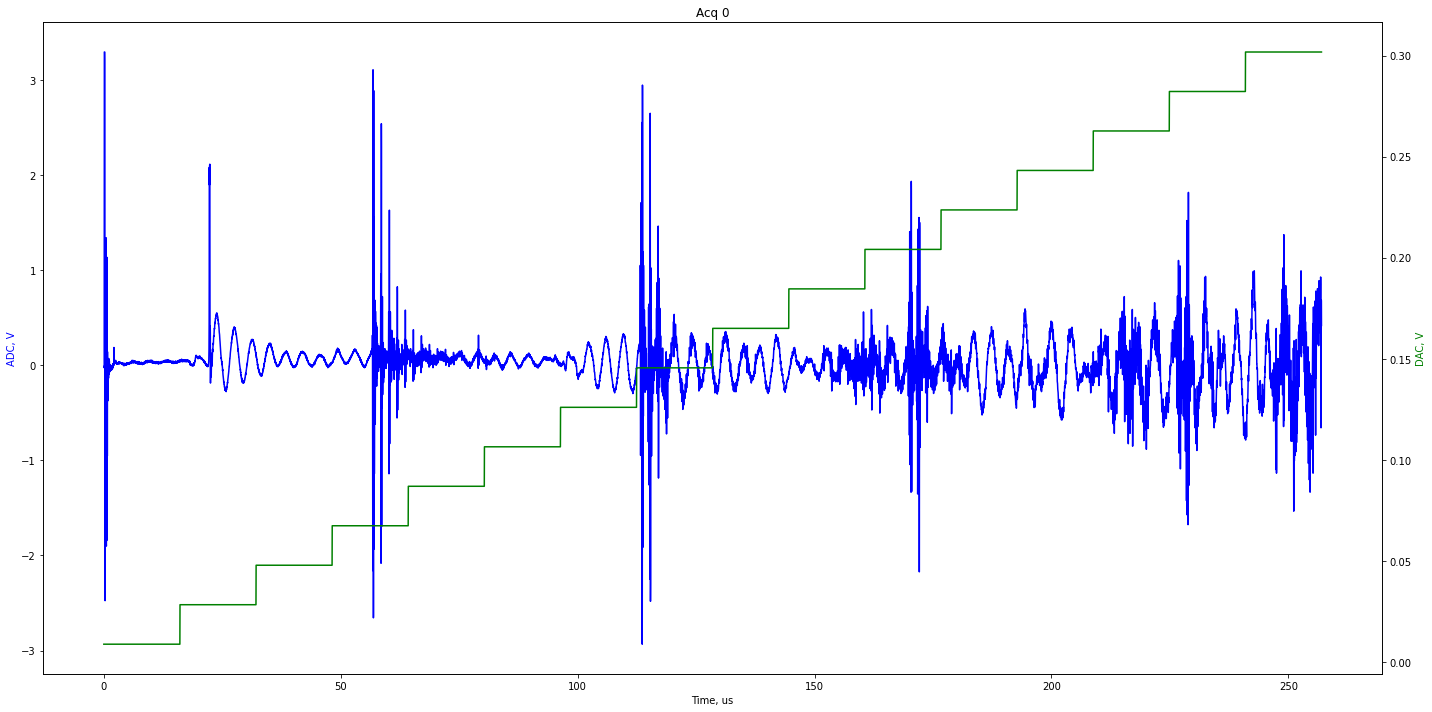

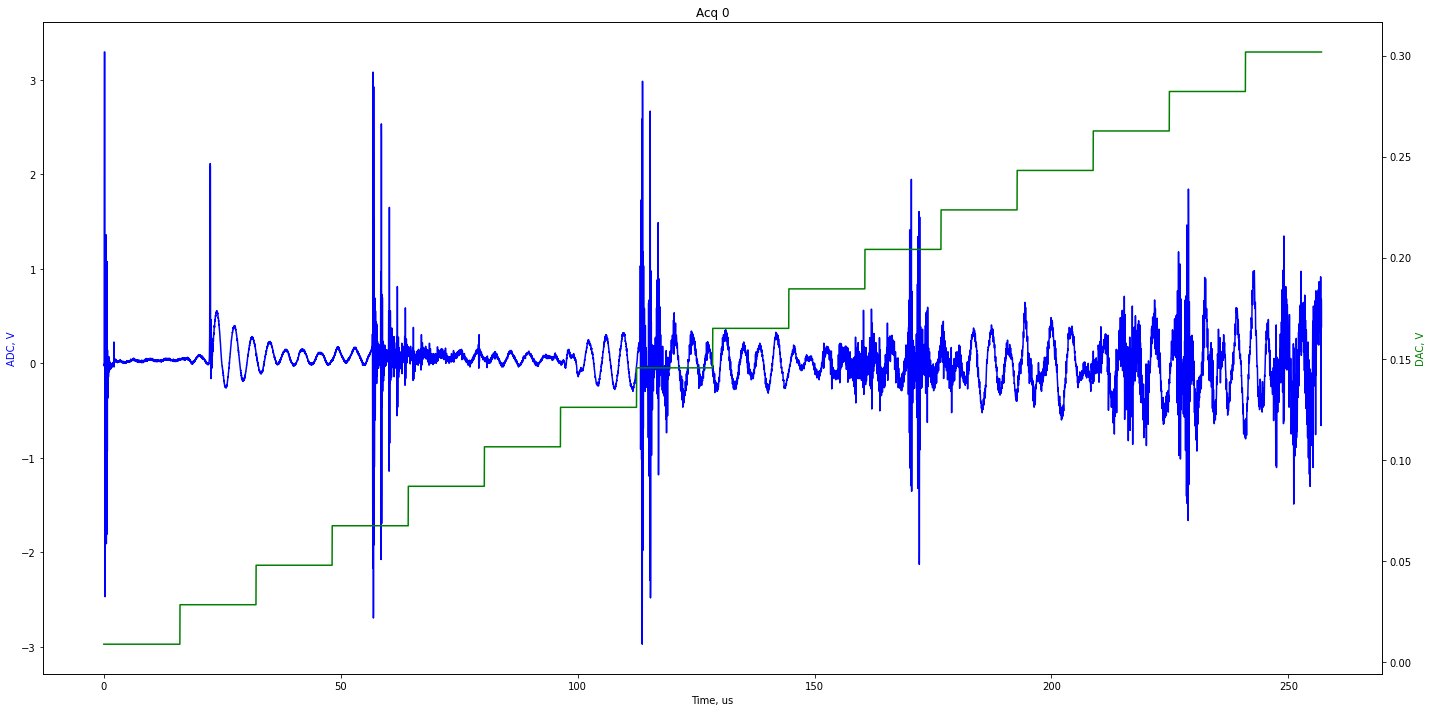

In [85]:
data = {}
data["gain"]=gain
data["double_rate"]="True"

for j in range(16):
    fpga.csr.ponw = j
    fpga.csr.interw = j
    fpga.csr.poffw = 4096-2*j
    data[j] = {}
    acq_res = fpga.do_acquisition(acq_lines=32, gain=gain, double_rate=True)
    plot_line("Acq 0", acq_res[0], gain)
    for i in range(32):
        data[j][i]=acq_res[i]

In [86]:
data = {}
data["gain"]=gain
data["double_rate"]="True"
for i in range(32):
    data[i]=acq_res[i]

import json

with open('smallpiezo_lines_3.json', 'w') as fp:
    json.dump(data, fp)

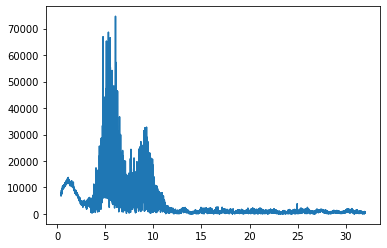

In [93]:
FFT = np.abs(np.fft.fft(acq_res[0]))
f = [x*64/len(FFT) for x in range(len(FFT))]
plt.plot(f[100:int(len(FFT)/2)],FFT[100:int(len(FFT)/2)])
plt.title("Freq")
plt.xlabel(MHz)

In [112]:
with open('smallpiezo_lines_finding_timing.json', 'r') as fp:
    data = json.load(fp)

In [130]:
len(data['1']['1'])

16384

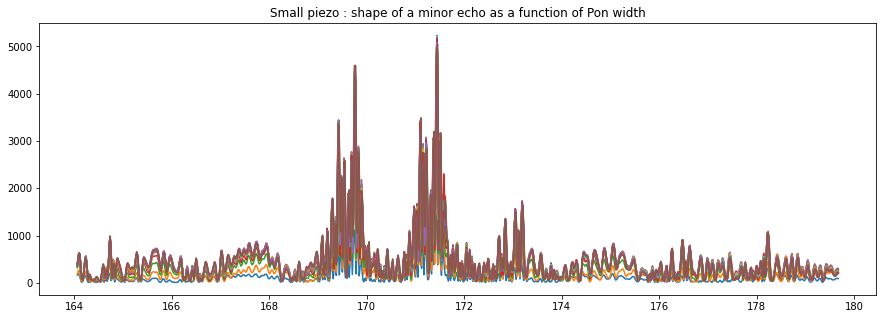

In [133]:
plt.figure(figsize=(15,5))
data["max"] = []
t = [(10500+x)/64.0 for x in range(1000)]
for k in range(16):
    k = str(k)
    data["peak_"+str(k)] = np.abs(data[k]["0"]-np.mean(data[k]["0"]))[10500:11500]
    for j in range(14):
        data["peak_"+str(k)] += np.abs(data[k][str(j+1)]-np.mean(data[k][str(j+1)]))[10500:11500]
    plt.plot(t,data["peak_"+str(k)])
    data["max"].append(np.max(data["peak_"+str(k)]))
plt.title("Small piezo : shape of a minor echo as a function of Pon width")
plt.savefig("smallprobe_echo.png")
plt.show()

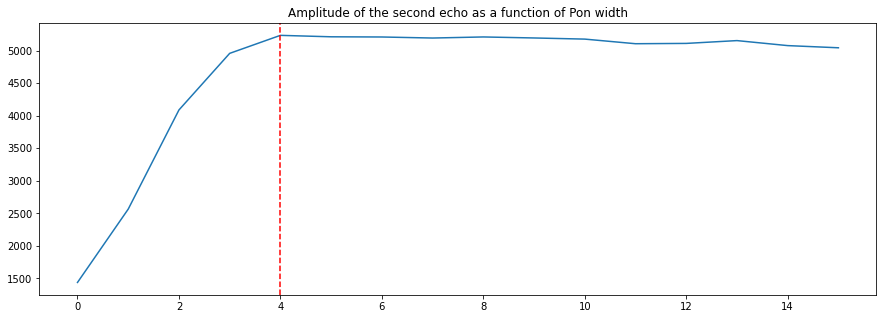

In [134]:
plt.figure(figsize=(15,5))
plt.plot(data["max"]) 
m = np.argmax(data["max"][0:50])
plt.axvline(m, color='r', linestyle='dashed')
plt.title("Amplitude of the second echo as a function of Pon width")
plt.savefig("smallprobe_amplitude.png")
plt.show()

In [240]:
def createData(filename):
    with open(filename, 'r') as fp:
        data = json.load(fp)
    odd = np.array(data["0"]-np.mean(data["0"]))
    even = np.array(data["1"]-np.mean(data["1"]))
    for k in range(15):
        if not (k%2):
            even = even + np.array(data[str(2*(k+1))]-np.mean(data[str(2*(k+1))]))
        else: 
            odd = odd + np.array(data[str(2*(k+1)+1)]-np.mean(data[str(2*(k+1)+1)]))
    signal = []
    for k in range(len(odd)):
        signal.append(odd[k])
        signal.append(even[k])
    t = [T*256/len(signal) for T in range(len(signal))]
    signal = [float(x/16.0) for x in signal]
    return t,signal

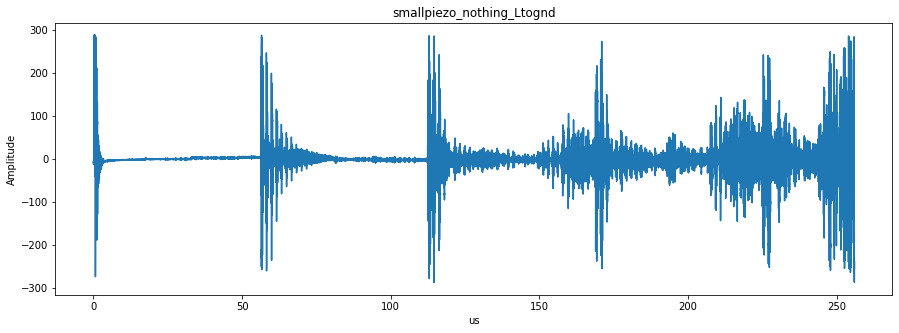

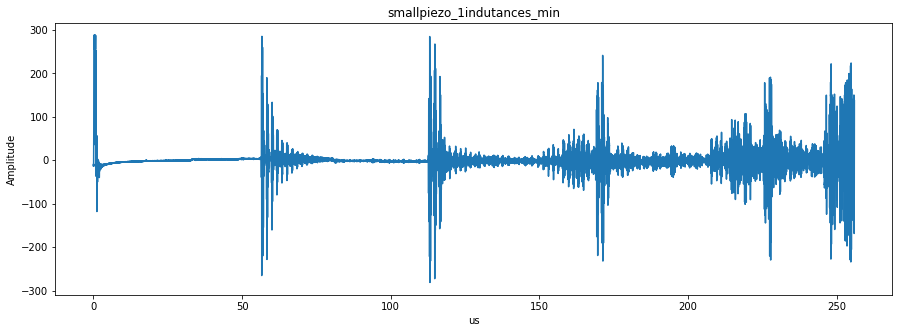

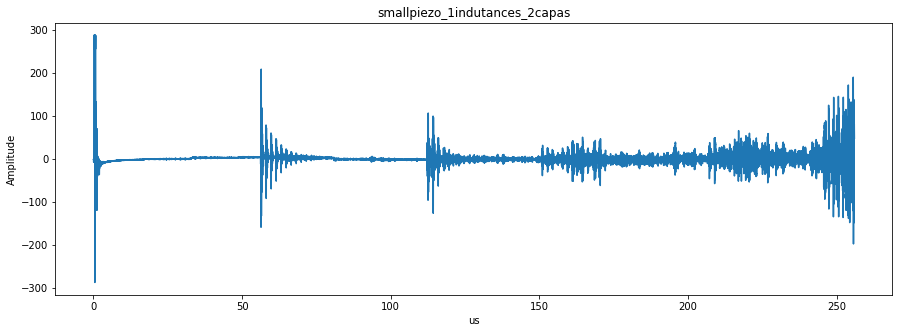

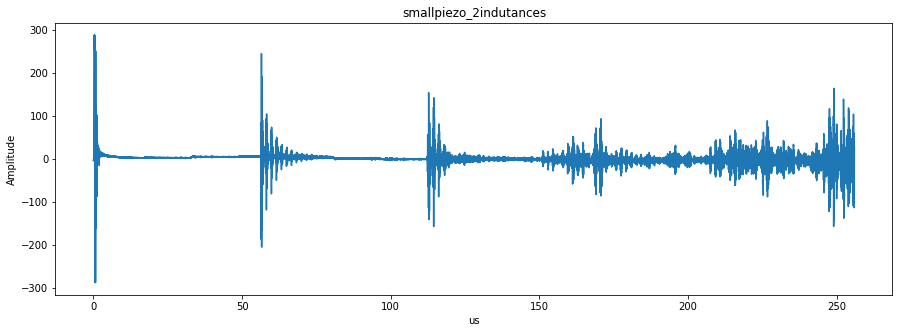

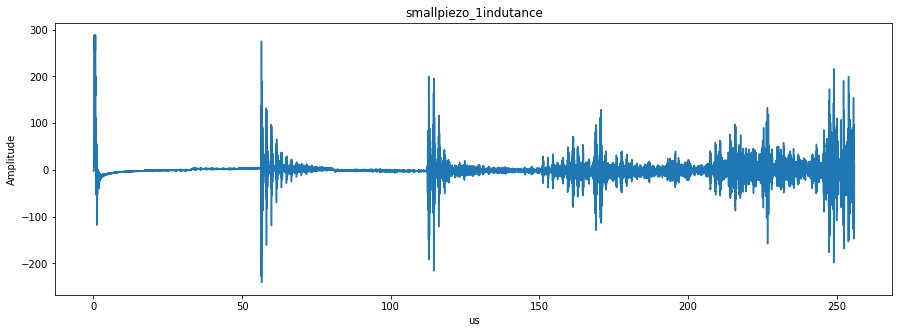

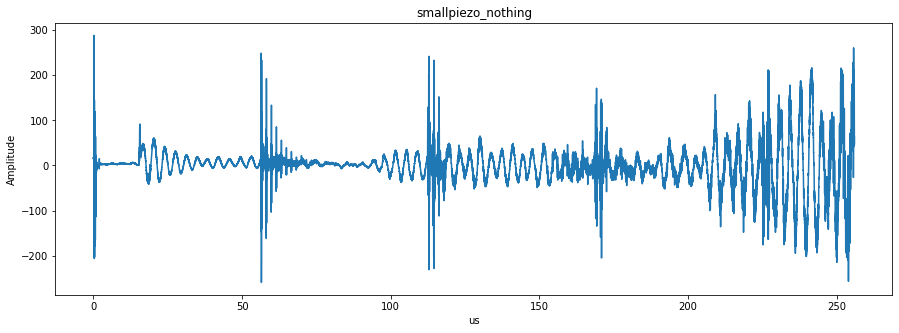

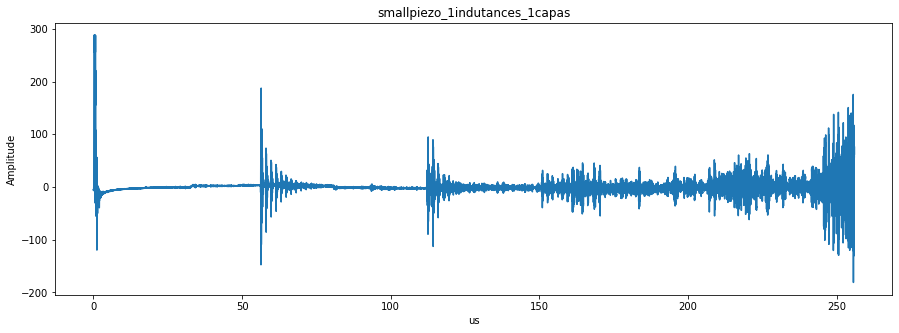

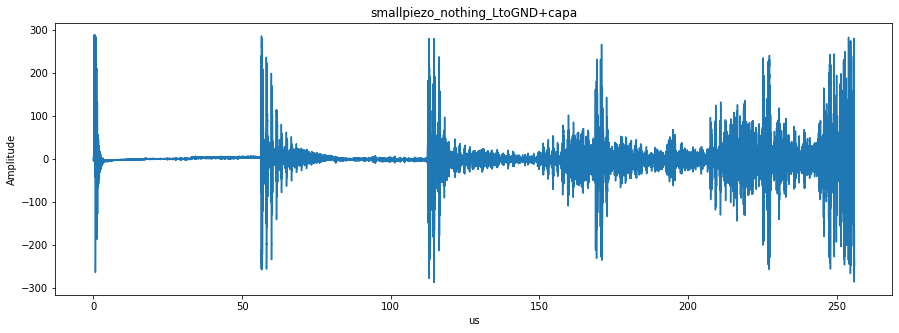

In [241]:
ALLJSON = {}
import os
for file in os.listdir("./"):
    if (file.endswith(".json")):
        if not file.endswith("smallpiezo_lines_finding_timing.json"):
            if not file.endswith("ALLJSON.json"):
                t,x = createData(file)
                plt.figure(figsize=(15,5))
                plt.plot(t,x)
                ALLJSON[file] = x
                plt.xlabel('us')
                plt.ylabel("Amplitude")
                plt.title(file.split(".")[0])
ALLJSON["t"] = t

with open('ALLJSON.json', 'w') as fp:
    json.dump(ALLJSON, fp)

In [242]:
ref = ALLJSON["smallpiezo_nothing.json"]
adapt = ALLJSON["smallpiezo_nothing_Ltognd.json"]
FFT_ref = np.abs(np.fft.fft(ref))
FFT_adapt = np.abs(np.fft.fft(adapt))
f = [x*128/len(FFT_ref) for x in range(len(FFT_ref))]
t = ALLJSON["t"]

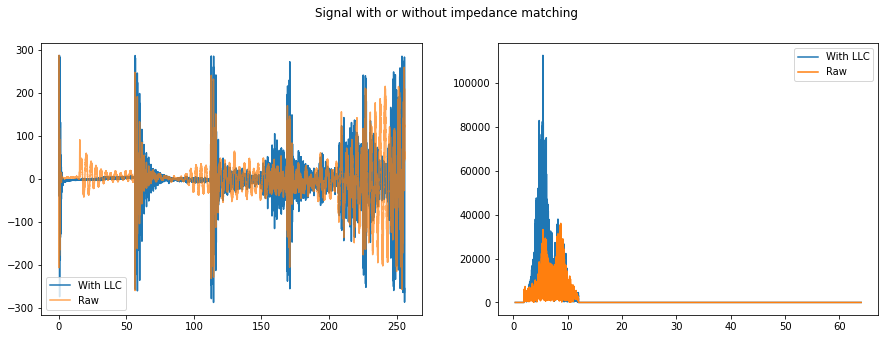

In [273]:

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5)) 
fig.suptitle('Signal with or without impedance matching')

ax1.plot(t,adapt,label="With LLC")
ax1.plot(t,ref,alpha=0.7,label="Raw")

ax2.plot(f[100:int(len(f)/2)],FFT_adapt[100:int(len(f)/2)],label="With LLC")
ax2.plot(f[100:int(len(f)/2)],FFT_ref[100:int(len(f)/2)],label="Raw")

ax1.legend()
ax2.legend()
plt.savefig("LC_impact.jpg")

In [274]:
FFTref_filt = np.fft.fft(ref)
FFTadapt_filt = np.fft.fft(adapt)

for k in range(int(len(FFT_ref)/2 +1 )):
    if (f[k] < 2.0) or (f[k] > 12):
        FFTadapt_filt[k] = 0
        FFTadapt_filt[-k] = 0
        FFTref_filt[k] = 0
        FFTref_filt[-k] = 0

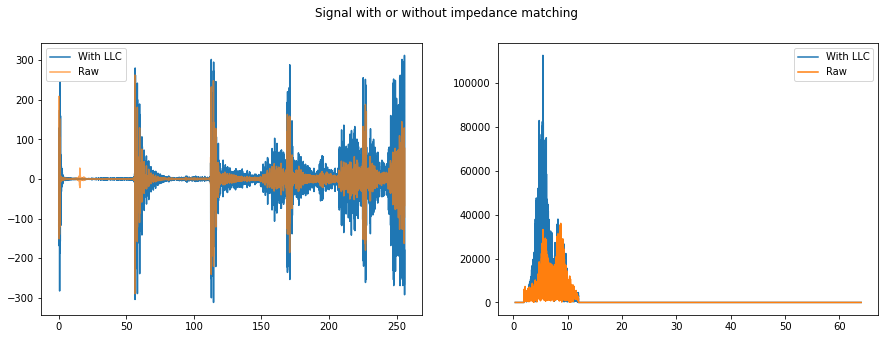

In [275]:
adapt_filt = np.real(np.fft.ifft(FFTadapt_filt))
ref_filt = np.real(np.fft.ifft(FFTref_filt))

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5)) 
fig.suptitle('Signal with or without impedance matching')

ax1.plot(t,adapt_filt,label="With LLC")
ax1.plot(t,ref_filt,alpha=0.7,label="Raw")

ax2.plot(f[100:int(len(f)/2)],np.abs(FFTadapt_filt[100:int(len(f)/2)]),label="With LLC")
ax2.plot(f[100:int(len(f)/2)],np.abs(FFTref_filt[100:int(len(f)/2)]),label="Raw")

ax1.legend()
ax2.legend()
plt.savefig("LC_impact_filtered.jpg")

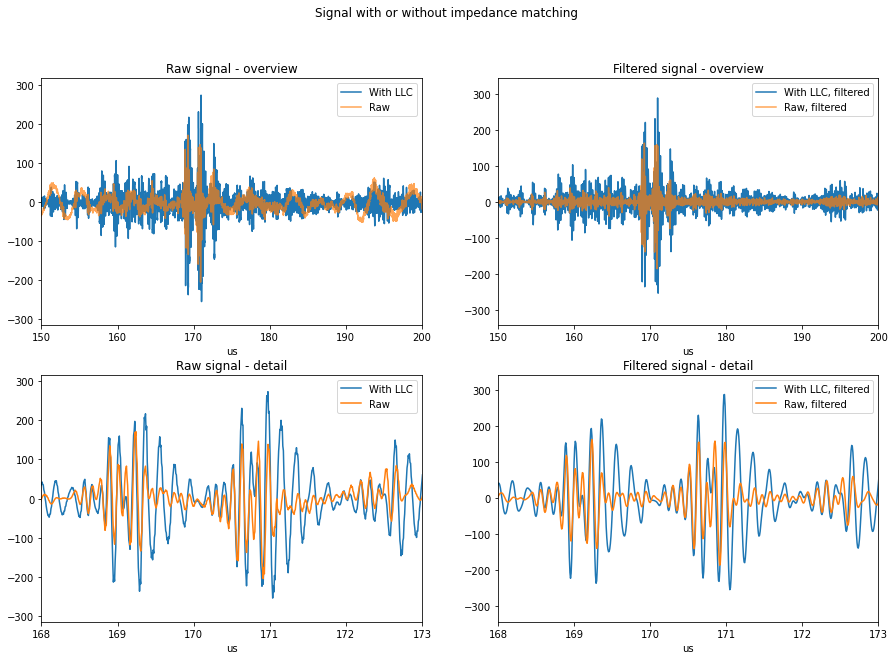

In [282]:
fig, ax = plt.subplots(2, 2,figsize=(15,10)) 
fig.suptitle('Signal with or without impedance matching')

ax[0,0].plot(t,adapt,label="With LLC")
ax[0,0].plot(t,ref,alpha=0.7,label="Raw")
ax[0,0].set_xlim([150, 200])
ax[0,0].set_xlabel('us')
ax[0,0].set_title('Raw signal - overview')

ax[0,1].plot(t,adapt_filt,label="With LLC, filtered")
ax[0,1].plot(t,ref_filt,alpha=0.7,label="Raw, filtered")
ax[0,1].set_xlim([150, 200])
ax[0,1].set_xlabel('us')
ax[0,1].set_title('Filtered signal - overview')

ax[0,0].legend()
ax[0,1].legend()

ax[1,0].plot(t,adapt,label="With LLC")
ax[1,0].plot(t,ref,label="Raw")
ax[1,0].set_xlim([168, 173])
ax[1,0].set_xlabel('us')
ax[1,0].set_title('Raw signal - detail')

ax[1,1].plot(t,adapt_filt,label="With LLC, filtered")
ax[1,1].plot(t,ref_filt,label="Raw, filtered")
ax[1,1].set_xlim([168, 173])
ax[1,1].set_xlabel('us')
ax[1,1].set_title('Filtered signal - detail')

ax[1,0].legend()
ax[1,1].legend()

plt.savefig("LC_compared.jpg")

## Disconnect FPGA

In [24]:
# reset fpga again (optional)
fpga.reset()
# close FTDI interface
fpga.disconnect()

In [ ]:
smallpiezo_lines_finding_timing.json